In [82]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri

pandas2ri.activate()

# Import r packages

#importing R package custom.analytics and replacing . with _ in #package names to ensure no conflicts
d = {'package.dependencies': 'package_dot_dependencies',
     'package_dependencies': 'package_uscore_dependencies'}
# custom_analytics = importr('custom.analytics', 
#                    robject_translations = d)

bl = importr('bnlearn', robject_translations = d)
vn = importr('visNetwork', robject_translations = d)

## Intro

Eventually I would like to call the R functions in bnlearn through Python, so that I can do data pre- and post-processing in Python, which I am much more familiar with. rpy2 seems the best way to interact with R through Python. Some tutorials to help:

See https://code.likeagirl.io/walking-the-python-r-bridge-66b63bab0fbd
for tips on using with R from Python

Another good tutorial: https://community.alteryx.com/t5/Data-Science-Blog/RPy2-Combining-the-Power-of-R-Python-for-Data-Science/ba-p/138432

In [50]:
# structure = bl.empty_graph()
# structure

## In the meanwhile, do some data processing to make a nice dataframe that can be read in by R

In [83]:
# Read in seasonally-aggregated data
in_file = (r'../data/DataMatrices/Vansjø_seasonal_data_Van2.csv')
df = pd.read_csv(in_file, index_col=0)

df.index = pd.to_datetime(df.index) # Index was being read as a string; convert to datetime

df.head()

,Pptn,Temp,Wind_speed,PET,Q,TP_catch,chl-a_lake,TP_lake,colour_lake,PTI,...,Q_winterSum,Temp_subzero_winterSum,Wind_under_Q0.2_winterSum,Wind_under_Q0.4_winterSum,Wind_over_Q0.6_winterSum,Wind_over_Q0.8_winterSum,TP_lake_prevSummer,colour_lake_prevSummer,chl-a_lake_prevSummer,CyanoBiovol_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-31,22.434315,-8.091381,2.319355,0.000000,6095174.4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-04-30,80.992741,-2.933491,3.042222,38.550908,28217376.0,130.000000,3.971429,45.250000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-07-31,242.199218,14.449403,3.101087,341.791701,30799440.0,68.333333,12.169127,36.084127,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-10-31,351.676639,9.575229,3.547826,185.500285,56804025.6,113.500000,20.773333,51.061905,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-31,138.440254,-2.665732,3.696739,2.283018,38566540.8,NaN,NaN,NaN,NaN,NaN,...,69390950.4,116.0,40.0,67.0,71.0,38.0,43.573016,NaN,16.47123,NaN


In [52]:
# sorted(df.columns)

In [84]:
# Just select variables to be used in the BN, as well as 'Season' for splitting later
vars_longnames = [
        'chl-a_lake',
        'chl-a_lake_lag1',
        'chl-a_lake_prevSummer',
        'colour_lake',
        'colour_lake_lag1',
        'colour_lake_prevSummer',
        'CyanoBiovol',
        'CyanoBiovol_lag1',
        'Pptn_lag1',
        'Rain_day_winterSum',
        'TP_lake',
        'TP_lake_lag1',
        'TP_lake_prevSummer',
        'Wind_under_Q0.4',
        'Wind_over_Q0.6',
        'Season'
       ]

var_dict = {'chl-a_lake': 'chla',
            'chl-a_lake_lag1': 'chla_lag1',
            'chl-a_lake_prevSummer': 'chla_prevSummer',
            'colour_lake': 'colour',
            'colour_lake_lag1': 'colour_lag1',
            'colour_lake_prevSummer': 'colour_prevSummer',
            'CyanoBiovol': 'Cyano',
            'CyanoBiovol_lag1': 'Cyano_lag1',
            'Pptn_lag1': 'Rain_lag1',
            'Rain_day_winterSum': 'Rainy_days_winter',
            'TP_lake': 'TP',
            'TP_lake_lag1': 'TP_lag1',
            'TP_lake_prevSummer': 'TP_prevSummer',
            'Wind_under_Q0.4': 'WindDays_under_Q0.4',
            'Wind_over_Q0.6': 'WindDays_over_Q0.6',
            'Season':'Season'
            }

In [85]:
var_list = []
for var in vars_longnames:
    new_varname = var_dict[var]
    var_list.append(new_varname)
var_list

['chla',
 'chla_lag1',
 'chla_prevSummer',
 'colour',
 'colour_lag1',
 'colour_prevSummer',
 'Cyano',
 'Cyano_lag1',
 'Rain_lag1',
 'Rainy_days_winter',
 'TP',
 'TP_lag1',
 'TP_prevSummer',
 'WindDays_under_Q0.4',
 'WindDays_over_Q0.6',
 'Season']

In [86]:
# Drop variables which won't be used in the analysis
df = df[vars_longnames]

# Rename column names using new short names
for var in df.columns:
    df[var_dict[var]] = df[var]
    
    # N.B. any variables which have same names in both sides of the dict need to be in this if loop
    if var != 'Season':
        df.drop(var, axis=1, inplace=True)
        
df.head()

,Season,chla,chla_lag1,chla_prevSummer,colour,colour_lag1,colour_prevSummer,Cyano,Cyano_lag1,Rain_lag1,Rainy_days_winter,TP,TP_lag1,TP_prevSummer,WindDays_under_Q0.4,WindDays_over_Q0.6
Date,,,,,,,,,,,,,,,,
1980-01-31,wint,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,6.0
1980-04-30,spr,3.971429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.434315,NaN,45.250000,NaN,NaN,37.0,27.0
1980-07-31,summ,12.169127,3.971429,NaN,NaN,NaN,NaN,NaN,NaN,80.992741,NaN,36.084127,45.250000,NaN,43.0,27.0
1980-10-31,aut,20.773333,12.169127,NaN,NaN,NaN,NaN,NaN,NaN,242.199218,NaN,51.061905,36.084127,NaN,38.0,33.0
1981-01-31,wint,NaN,20.773333,16.47123,NaN,NaN,NaN,NaN,NaN,351.676639,102.0,NaN,51.061905,43.573016,33.0,43.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


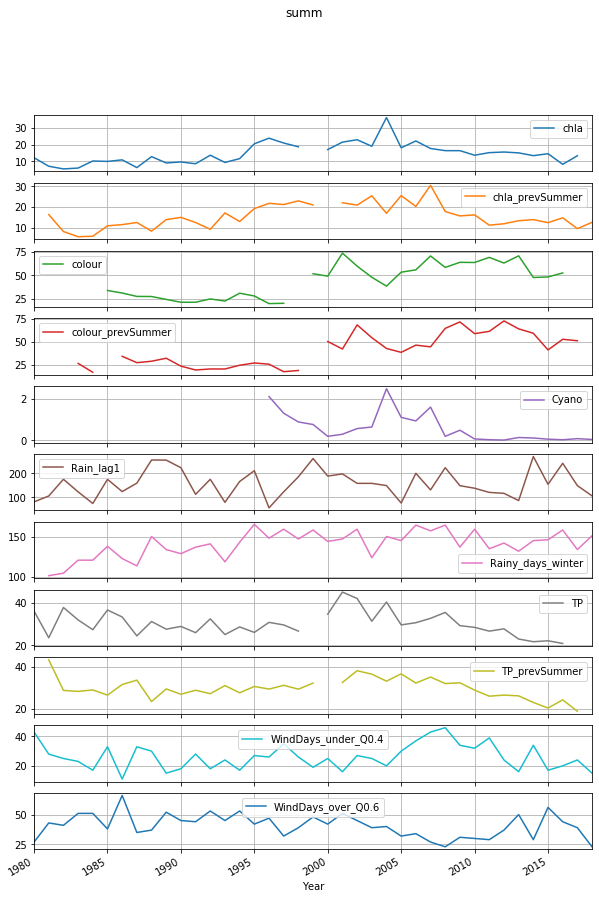

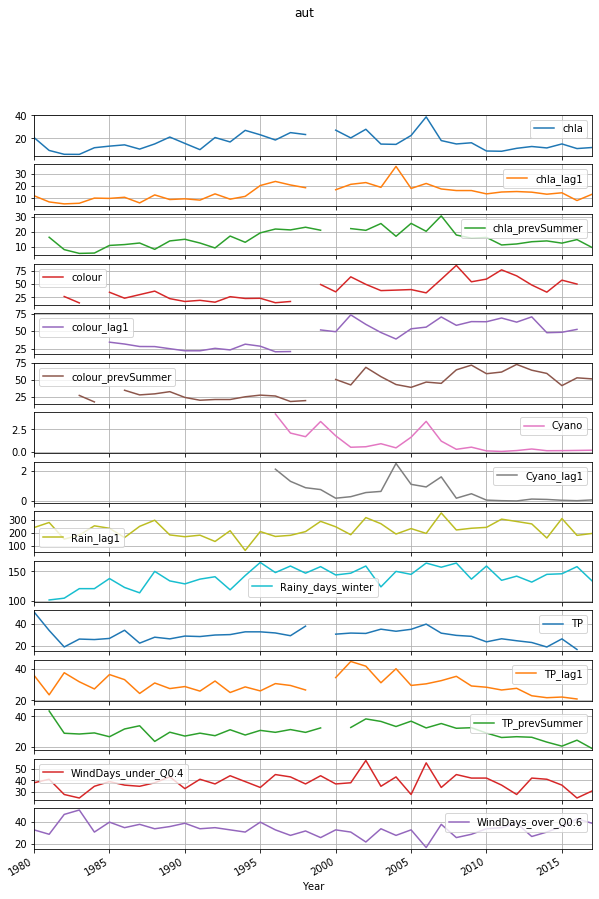

In [87]:
# Split into early summer and late summer and write to csv
for season in ['summ','aut']:
    
    temp_df = df.loc[df['Season']==season, :] # Just pick season of interest
    
    # Add year column and reindex using year; drop season column
    temp_df['Year'] = temp_df.index.year
    temp_df.set_index('Year', inplace=True)
    temp_df.drop('Season', axis=1, inplace=True)
    
    # If early summer, don't have data for most of the _lag1 variables, so drop these
    if season == 'summ':
        temp_df.drop(['chla_lag1','TP_lag1','colour_lag1','Cyano_lag1'], axis=1, inplace=True)
    
    temp_df.to_csv(r'../data/DataMatrices/VansjøData_%s_forBN.csv' %season)
    
    # Plot time series and save figures
    temp_df.plot(subplots=True, figsize=(10,15), title='%s'%season, grid=True)
    plt.savefig(r'../Figures/VansjøData_%s_timeseries.png' %season)
#     plt.show()
    
# Same again, but this time plot and save the plots

In [74]:
type(temp_df.index[0])

numpy.int64

## Discretize the data

For starters, just do simple split into 3 terciles, and label them all 'low', 'average', 'high'